In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import tensorflow as tf

tf.__version__

'2.2.0'

In [4]:
from tensorflow.keras import layers

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

In [6]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 255 # Normalize the images to [-0.5, 0.5]
BUFFER_SIZE = 60000
BATCH_SIZE = 64
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 注意：batch size 没有限制

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

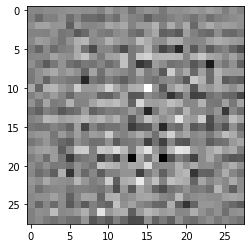

In [8]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[2.0378997e-05]], shape=(1, 1), dtype=float32)


In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(lr=2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=2e-4)

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

In [14]:
EPOCHS = 20
NOISE_DIM = 100
NUM_EXAMPLES = 64

In [15]:
def generate_and_save_images(model, epoch, test_input):
  # 注意 training` 设定为 False
  # 因此，所有层都在推理模式下运行（batchnorm）。
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(8, 8, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('pics/image_at_epoch_{:04d}.png'.format(epoch))
    # plt.show()

In [16]:
seed = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [17]:
def train(dataset, epochs):
    start = time.clock()
    for epoch in range(epochs):
        total_gen_loss = 0
        total_disc_loss = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
        # display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        print('Epoch %d, Generator loss: %.5f' % (epoch+1, total_gen_loss))
        print('Epoch %d, Discriminator loss: %.3f' % (epoch+1, total_disc_loss))
        # 每15个epoch保存一次模型
        # if (epoch + 1) % 15 == 0:
            # checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time for training is %.3f' % (time.clock()-start))
    # display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

Epoch 1, Generator loss: 1870.50903
Epoch 1, Discriminator loss: 570.007
Epoch 2, Generator loss: 2089.19067
Epoch 2, Discriminator loss: 531.180
Epoch 3, Generator loss: 2203.58252
Epoch 3, Discriminator loss: 518.669
Epoch 4, Generator loss: 2140.36328
Epoch 4, Discriminator loss: 563.746
Epoch 5, Generator loss: 2107.04688
Epoch 5, Discriminator loss: 582.790
Epoch 6, Generator loss: 2092.71265
Epoch 6, Discriminator loss: 599.205
Epoch 7, Generator loss: 2080.83325
Epoch 7, Discriminator loss: 618.538
Epoch 8, Generator loss: 2028.10059
Epoch 8, Discriminator loss: 636.037
Epoch 9, Generator loss: 2044.33008
Epoch 9, Discriminator loss: 628.596
Epoch 10, Generator loss: 2077.44531
Epoch 10, Discriminator loss: 631.002
Epoch 11, Generator loss: 2072.17456
Epoch 11, Discriminator loss: 632.665
Epoch 12, Generator loss: 2085.37549
Epoch 12, Discriminator loss: 633.552
Epoch 13, Generator loss: 2099.44824
Epoch 13, Discriminator loss: 634.483
Epoch 14, Generator loss: 2206.78784
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


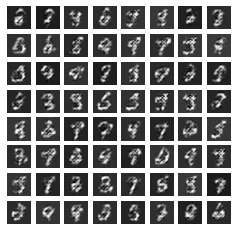

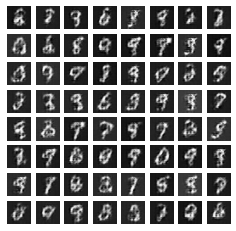

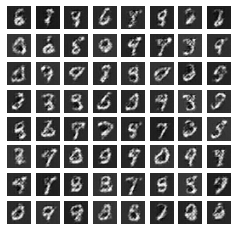

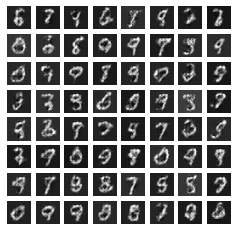

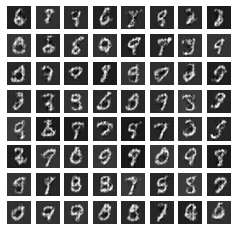

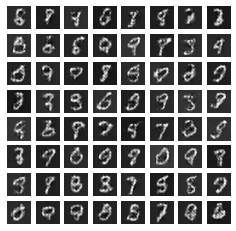

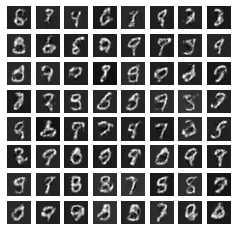

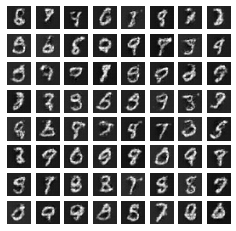

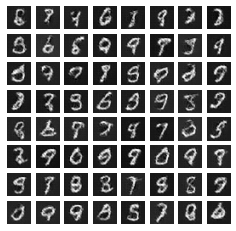

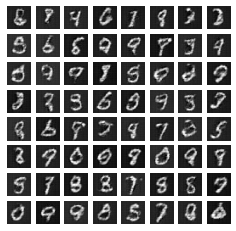

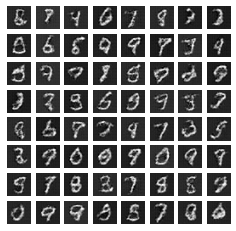

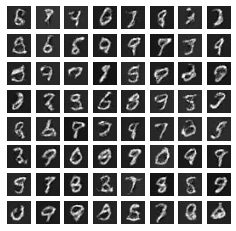

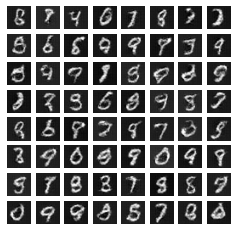

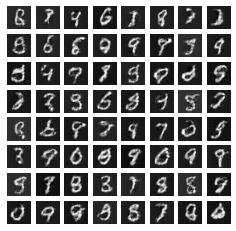

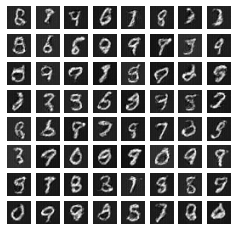

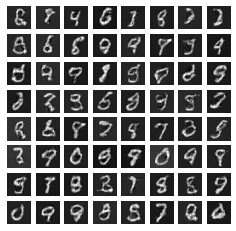

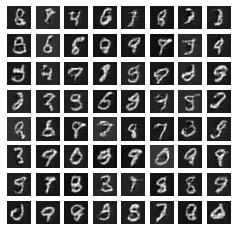

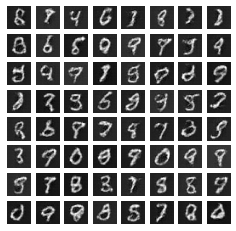

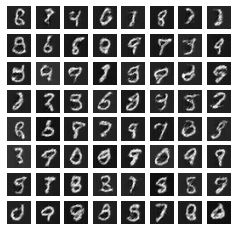

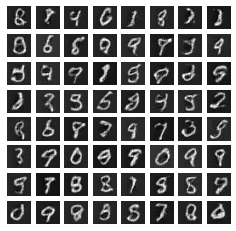

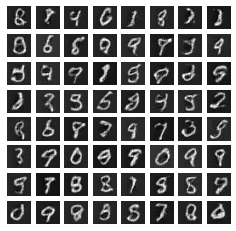

In [19]:
train(train_dataset, EPOCHS)